In [1]:
import numpy as np
import operator
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


## Reading dataset  
[Dataset link](https://www.kaggle.com/arhamrumi/amazon-reviews-eda-20012018)  
&nbsp;


In [2]:
sports = pd.read_csv("Sports_and_Outdoors.csv")
sports.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12969732 entries, 0 to 12969731
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   rating      int64 
 1   verified    bool  
 2   reviewerID  object
 3   product_id  object
 4   date        int64 
 5   vote        object
dtypes: bool(1), int64(2), object(3)
memory usage: 507.1+ MB


### Dropping columns not used for analysis
&nbsp;

In [3]:
sports.drop(['verified', 'vote'], axis=1, inplace=True)
sports = sports.sort_values('date', ascending=False)
sports.head()


,rating,reviewerID,product_id,date
12968859,3,AAL07KPFE0VFI,B01HIT0QDG,1538697600
12969474,5,A39ANO7WWQ9PE8,B01HJA3STS,1538697600
12969475,5,A4HCTG3TV7UPM,B01HJA3STS,1538611200
12969105,1,A30DF0WFD9U1PT,B01HIY7NPU,1538611200
12965742,5,A2WCAIO2XACZ01,B01HGSLB6K,1538611200


In [4]:
products = sports['product_id'].unique()
users = sports['reviewerID'].unique()
print('Number of unique products', len(products))
print('Number of unique users', len(users))


Number of unique products 957764
Number of unique users 6703391


&nbsp;
* Making a dictionary to store all ratings given by users to a particular product  
&nbsp;

In [5]:
all_products = defaultdict(dict)
for ind in sports.itertuples():
    all_products[ind.product_id][ind.reviewerID] = ind.rating
all_products = dict(all_products)


&nbsp;
* Removing all products for which only 1 rating has been given   
&nbsp;


In [6]:
new_all = defaultdict(dict)
product_id_nottake = set()
for i, val in all_products.items():
    if len(val) > 1:
        new_all[i] = val.copy()
    else:
        product_id_nottake.add(i)
new_all = dict(new_all)
all_products = new_all


&nbsp;
* Making a dictionary to store all ratings given to products by a particular user  
(Note that the products which had only 1 rating will not be reflected in this dictionary)   
&nbsp;

In [7]:
all_users = defaultdict(dict)
for ind in sports.itertuples():
    if ind.product_id not in product_id_nottake:
        all_users[ind.reviewerID][ind.product_id] = ind.rating
all_users = dict(all_users)


&nbsp;
## Making the data centered around zero

> This is a preprocessing step which helps us in computing the **Pearson correlation**.   

$\Large r =\Large\frac{\Large\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\Large\sum\left(x_{i}-\bar{x}\right)^{2} \sum\left(y_{i}-\bar{y}\right)^{2}}}$  

$r = $ Correlation coefficient  
$ x_{i} = $	values of the x-variable in a sample  
$\bar{x} = $	mean of the values of the x-variable  
$ y_{i} = $	values of the y-variable in a sample  
$\bar{y} = $	mean of the values of the y-variable  

We assume that a value of zero is given to all the products for which ratings haven't been given by a particular user.Thus, the set of all ratings for a given user can now be considered as a vector.  
&nbsp;

In [8]:
normalized_products = defaultdict(dict)
for i, val in all_products.items():
    normalized_products[i] = val.copy()
for i, val in normalized_products.items():
    values = list(val.values())
    mean_val = np.mean(values)
    for j in val:
        val[j] -= mean_val

&nbsp;
* For the each of the vectors defined in the previous step, we find the magnitudes.  
&nbsp; 

In [9]:
magnitudes = defaultdict(dict)

for i in normalized_products:
    values = list(normalized_products[i].values())
    magnitudes[i] = np.sqrt(np.sum(np.square(values)))


### TODO:

In [10]:
user = sports['reviewerID'].value_counts().idxmax()
sample_user = user
sample_user


'A3OXHLG6DIBRW8'

&nbsp;
* Getting all the products which have more than 1 rating and which have not been rated by the selected user.  
&nbsp;

In [23]:
rest = list(set(all_products.keys()) - set(all_users[sample_user]))


&nbsp;
* Choosing random 1000 products out of the list generated in the previous step  
&nbsp;

In [24]:
random1000 = np.random.choice(rest, size=1000)


&nbsp;
*  Getting the list of all products for which ratings have been given by the sample user.  
&nbsp;

In [25]:
compare_with = list(all_users[sample_user])


&nbsp;
For each of the products among the 1000 that we chose randomly, we try to predict the ratings which would have been given by the sample user. In order to acheive this, we find the similarity coefficient between the product whose rating is to be predicted, and all those products for which ratings have already been given by the sample user. Once we have the similarity coefficients, we predict the rating for that particular product using the formula :

$ \Large R(u, j) = \Large\frac{\Large\sum\limits_{i \ \epsilon \ compare \_ with} S_{ij} \ . \ R(u, i)}{\Large\sum S_{ij}} $  
&nbsp;

In [26]:
prediction_dict = defaultdict(dict)

for item in random1000:
    sine, calc = dict(), []
    for rated in compare_with:
        if rated not in magnitudes:
            continue
        coeff = 0
        for user in normalized_products[item]:
            if user not in normalized_products[rated]:
                continue
            coeff += normalized_products[item][user] * normalized_products[rated][user]
        if magnitudes[rated] == 0 and magnitudes[item] == 0:
            sine[rated] = 1
        elif magnitudes[rated] == 0 or magnitudes[item] == 0:
            sine[rated] = 0
        else:
            sine[rated] = coeff / (magnitudes[rated] * magnitudes[item])

    coeffs = list()

    sorted_sine = dict(
        sorted(sine.items(), key=operator.itemgetter(1), reverse=True))
    maxrange = min(len(sorted_sine.values()), 15)
    for i in sorted_sine:
        if sorted_sine[i] <= 0:
            break
        calc.append(sorted_sine[i] * all_users[sample_user][i])
        coeffs.append(sorted_sine[i])
        maxrange -= 1
        if maxrange == 0:
            break
    if len(coeffs) == 0:
        continue
    prediction_dict[item] = sum(calc) / sum(coeffs)


&nbsp;
Making a Data Frame having the products which the sample user has not rated yet, and the predicted rating value for the same.    
&nbsp;

In [32]:
# now we will pick top 100 items to recommend to user
prediction_df = pd.DataFrame(prediction_dict.items(), columns=[
                             "product_id", "predicted_rating"])
prediction_df.head()

,product_id,predicted_rating
0,B001AKT9GK,4.131513
1,B01CO2ORIC,4.857143
2,B0091LXNC6,4.857143
3,B002D4K9GG,5.000000
4,B00KRSF9O2,4.857143


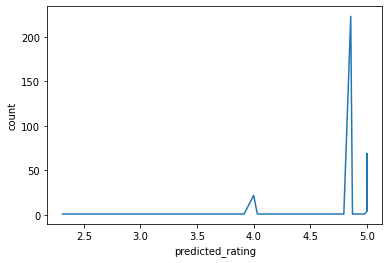

In [39]:
histogram = dict()
for i in prediction_df.itertuples():
    if i.predicted_rating not in histogram:
        histogram[i.predicted_rating] = 1
    else:
        histogram[i.predicted_rating] += 1
bar = sorted(histogram.items())
x, y = zip(*bar)
plt.plot(x, y)
plt.xlabel('predicted_rating')
plt.ylabel('count')
plt.show()

In [33]:
results = prediction_df.sort_values(by="predicted_rating", ascending=False)
recommended_products = list()
for i in range(min(100 , len(results))):
    recommended_products.append(results.iloc[i]['product_id'])
print("Top " + str(len(recommended_products)) + " Recommended products for user " + str(sample_user) + " -")
for i in recommended_products:
    print(i)


Top 100 Recommended products for user A3OXHLG6DIBRW8 -
B0014D497W
B0013VNCHS
B004E322DC
B001AML3TY
B0090XDXB6
B01CVT2M7G
B001NXD0XM
B0002Q9CFQ
B00UHBVEGG
B000E8BJGC
B007JTO2TK
B00PNU7HIK
B007HN69B2
B003TWT9LM
B0042DYXD6
B002MW0SRY
B000LH4VDO
B00ATWKBF8
B00BD5700Y
B000V2UJQM
B008VGQRG6
B0197XEITE
B00FSVP1OQ
B0095XQ4BW
B002LSAGVW
B00162UK0G
B00MGEBD0O
B001NU1XIO
B00284ADCQ
B00ZOKY7SW
B01167ZQH2
B000283EBW
B008MJBMGC
B00TT5LB9G
B0015UG2W4
B001MJUYHC
B00KO6KKCS
B00VMC9RXG
B0134RJNY4
B001CWULBI
B017NKZAAO
B00BD574XM
B00HL8BSDC
B0145R5X32
B00B7N7GEC
B00OUIS2U8
B00LNPBKDW
B00MWPM20W
B00N0NGPGC
B00563XH1A
B000Z47L9O
B00PY3NVCC
B00GBQQ7EA
B01EXZ6UE2
B000UPJQ3M
B00CVUVG2S
B001ACPQ2O
B00J7KQIZU
B01AALXG4A
B01AJITA5I
B000A7NWKS
B001RXWD9A
B001ANL3HU
B00DFSN6BY
B00YFUJ12E
B0010F9XFM
B002D4K9GG
B001GLUNCW
B00KU00NQ6
B00K37CDUA
B00OGPYAII
B001H99QUS
B001A4B6D0
B00R5QX5HC
B00P2CW6NA
B004QCJVT4
B007TTMK7G
B00HQQG2CQ
B000BODMOG
B000KOPP38
B016A6Z3Z4
B00IMUAJNI
B00AS0LQBY
B001QGW3A2
B004Y7EEH0
B00I4KPEPO